In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import talib
from scipy.optimize import leastsq

from hft import factor_post,plt_oneday,factor_rank

In [3]:
para = {
    "start_date": str(20190201),
    "end_date": str(20190330),
    "product_type": "index",
    "t_list": ["i000905"],
    "factor":""
}
client_id = "1557817716" #请填写你的ID

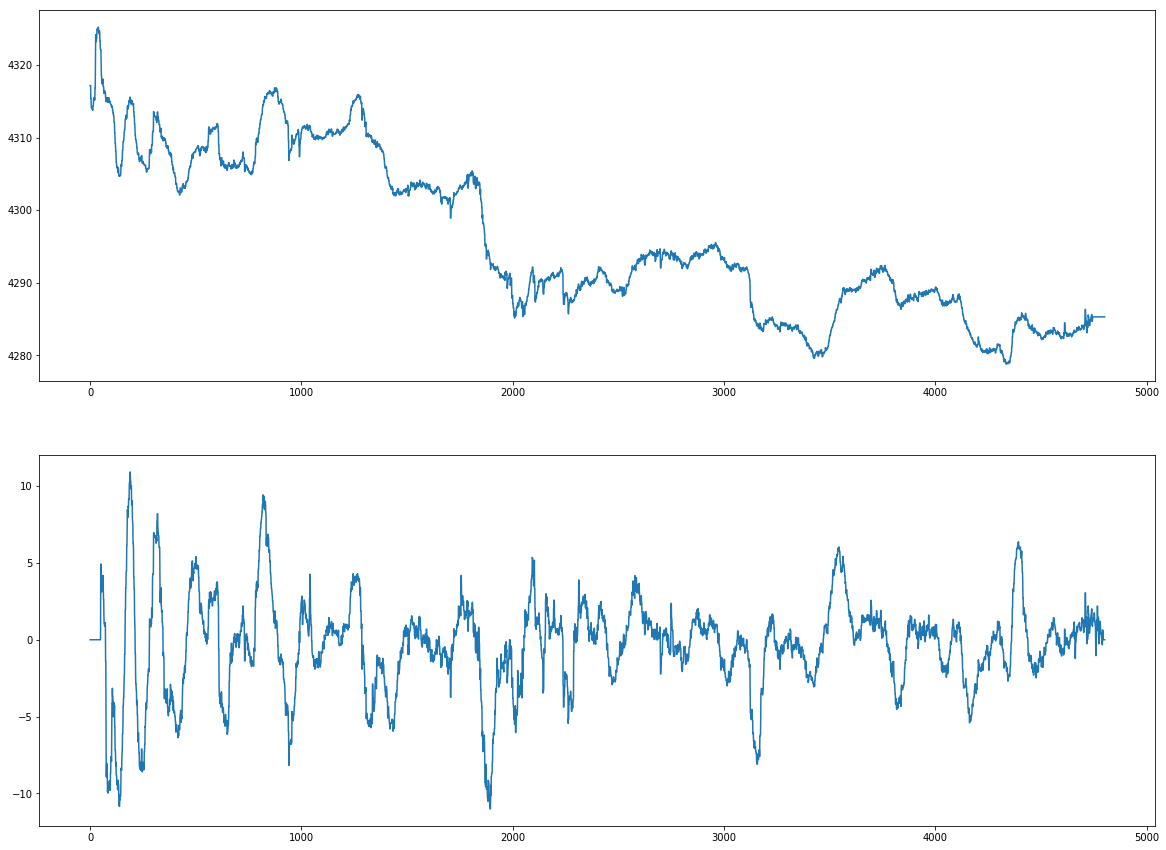

In [4]:
#  现象观察（量价曲线）
df=pd.read_csv('sample_data.csv')
V = df['val']/df['mp']
def get_V(V,n=4):    # 可以考虑加权平均，把更多的注意放到最近的日期
    temp = []
    for i in range(1,n+1):
        temp.append(np.sum(V[:i]))
    for i in range(n,len(V)):
        V_n = np.sum(V[i-n:i+1])
        temp.append(V_n)
    return temp
v=get_V(V)
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
plt.plot(df['Unnamed: 0'],df['mp'])
plt.subplot(2,1,2)
#plt.plot(df['Unnamed: 0'].iloc[5:],v[5:])
MOM = talib.MOM(df['mp'], timeperiod=50)
MOM = MOM.fillna(0)
plt.plot(df['Unnamed: 0'],MOM)

In [5]:
#  短期曲线拟合试验
EMA_l = talib.MA(df['mp'],26,matype=1)
EMA_s = talib.MA(df['mp'],4,matype=1)
index = EMA_s - EMA_l
index = index.fillna(0)

def fit_func(p, x):
    f = np.poly1d(p)
    return f(x)

def residuals_func(p, y, x):
    ret = (fit_func(p, x) - y)
    return ret

def simulate(x,y,n=9):
    p_init = np.random.randn(n) 
    plsq = leastsq(residuals_func, p_init, args=(y, x))
    #plt.plot(x, y, label='real')
    #plt.plot(x, fit_func(plsq[0], x), label='fitted curve')
    #plt.legend()
    #plt.show()
    return plsq
# 注意：不使用未来数据，对每个时间点，只使用该时间点之前的数据进行因子计算
t = 20
index_s=[]
for i in range(t):
    index_s.append(index[i])
for i in range(t,len(index)):   # 发现因子特征存在滞后性，采取平滑-预估策略
    plsq = simulate(list(range(t)),index[i-t:i],n=5)  # 对时间点i取之前的t个时间点进行短时特征拟合
    index_s.append(fit_func(plsq[0], t+17))

index_s=(index_s-np.mean(index_s))/np.std(index_s)


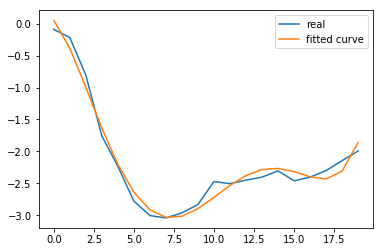

In [6]:
#  短期曲线拟合试验
n=6
k=20
t=50
p_init = np.random.randn(n) 
plsq = leastsq(residuals_func, p_init, args=(index[t:t+k], list(range(k))))
plt.plot(list(range(k)), index[t:t+k], label='real')
plt.plot(list(range(k)), fit_func(plsq[0], list(range(k))), label='fitted curve')
plt.legend()
plt.show()

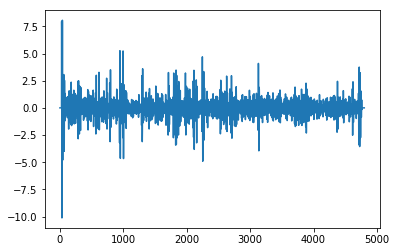

In [7]:
plt.plot(list(range(len(index_s))), (index_s-np.mean(index_s))/np.std(index_s), label='fitted curve')

In [8]:
# 局部加权线性回归方法试验
from numpy import *
EMA_l = talib.MA(df['mp'],26,matype=1)
EMA_l = EMA_l.fillna(np.mean(EMA_l[25:])) 
yArr = np.array(EMA_l)
xArr = np.array(df['Unnamed: 0'])
xArr = np.c_[[1]*len(xArr),xArr]
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]     #
        weights[j,j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T *(weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat
# yHat = lwlrTest(xArr,xArr,yArr,0.003)


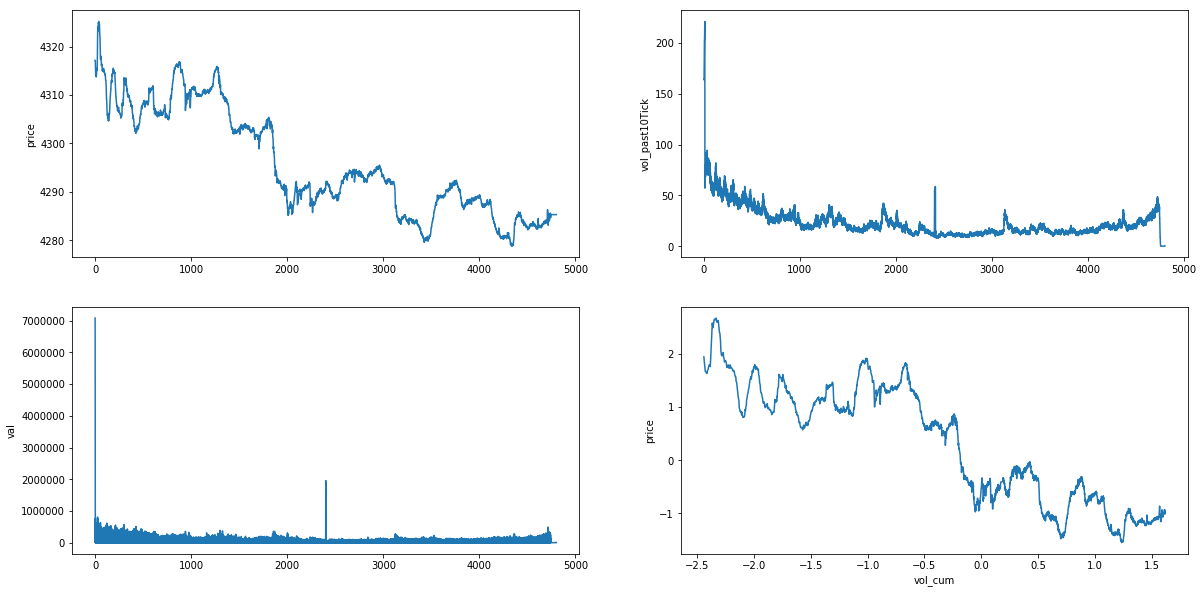

In [12]:
# vol中多夹杂0值，影响相关性判断，考虑使用vol_cum 或 vol_mean(Tick)
price = (df['mp']-np.mean(df['mp']))/np.std(df['mp'])
vol = (df['val_cum']-np.mean(df['val_cum']))/np.std(df['val_cum'])
V = df['val']/df['mp']
def get_V(V,n=10):    
    temp = []
    for i in range(1,n+1):
        temp.append(np.sum(V[:i])/n)
    for i in range(n,len(V)):
        V_n = np.sum(V[i-n:i+1])/n
        temp.append(V_n)
    return temp
a=get_V(V)
# f, ax = plt.subplots(figsize=(20, 5))
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(df['mp'])
plt.ylabel('price')
plt.subplot(2,2,3)
plt.plot(df['val'])
plt.ylabel('val')
plt.subplot(2,2,2)
plt.plot(a)
plt.ylabel('vol_past10Tick')
plt.subplot(2,2,4)
plt.plot(vol,price)
plt.xlabel('vol_cum')
plt.ylabel('price')
plt.show()

# 编写一个因子

这个cell是用于本地测试你的因子是否编写正确，检查无误后，将calc_factor函数填到下面cell的字符串中，用于提交

In [ ]:
def calc_factor(df):
   
    # 策略1 ：0.002099
    macd, macdsignal, macdhist = talib.MACD(df['mp'], fastperiod=12, slowperiod=26, signalperiod=9)
    macd = macd.fillna(0)
    macdsignal = macdsignal.fillna(0)
    index_macd = macd-macdsignal
    index_macd = (index_macd-np.mean(index_macd))/np.std(index_macd)
    # 价格距离
    d = 50
    HP = []
    for i in range(d):
        HP.append(1)
    for i in range(d,len(df)):
        ind_max = np.max(df['mp'].iloc[i-d:i])
        ind_HP = df['mp'].iloc[i]/ind_max
        HP.append(ind_HP)
    index_HP = pd.Series(np.log(HP))
    # 指数评价
    EMA_l = talib.MA(df['mp'],26,matype=1)
    EMA_s = talib.MA(df['mp'],4,matype=1)
    index = EMA_s - EMA_l
    index = index.fillna(0)
    # 价量关系
    V = df['val']/df['mp']
    def get_V(V,n=10):    
        temp = []
        for i in range(1,n+1):
            temp.append(np.sum(V[:i])/n)
        for i in range(n,len(V)):
            V_n = np.sum(V[i-n:i+1])/n
            temp.append(V_n)
        return temp
    #a=get_V(V)
    b=EMA_l/talib.MA(V,30,matype=1)
    b[np.isinf(b)]=0
    b=(b-np.mean(b))/np.std(b)
    index = 0.9*index+10.5*index_HP+0.1*b+0.01*index_macd
     # 中性化
    max_range = index.quantile(0.9)
    min_range = index.quantile(0.1)
    for i in range(len(index)):
        if index[i]>max_range:
            index[i]=max_range
        elif index[i]<min_range:
            index[i]=min_range
    return index

    # 策略2：线下0.0036，线上超时运行
#from scipy.optimize import leastsq
#from scipy.optimize import leastsq
#def calc_factor(df):
#    EMA_l = talib.MA(df['mp'],26,matype=1)
#    EMA_s = talib.MA(df['mp'],4,matype=1)
#    index = EMA_s - EMA_l
#    index = index.fillna(0)
#    def fit_func(p, x):
#        f = np.poly1d(p)
#        return f(x)
#
#    def residuals_func(p, y, x):
#        ret = (fit_func(p, x) - y)
#        return ret
#
#    def simulate(x,y,n=9):
#        p_init = np.random.randn(n) 
#        plsq = leastsq(residuals_func, p_init, args=(y, x))
#        return plsq
#
#    t = 20
#    index_s=[]
#    for i in range(t):
#        index_s.append(index[i])
#    for i in range(t,len(index)):  
#        plsq = simulate(list(range(t)),index[i-t:i],n=6) 
#        index_s.append(fit_func(plsq[0], t+17))
#
#    index_s=(index_s-np.mean(index_s))/np.std(index_s)
#    
#    return index_s

    # 1.价和量的相关系数——
    # 考虑三种组合：量价因子(窗口时间内价和量的pearson相关系数)、反转因子、量价因子+反转因子
    # 动量因子,因子有效   标准化会降低表现
    #MOM = talib.MOM(df['mp'], timeperiod=5)
    #index = MOM.fillna(0)

    # 2.价的历史收益率
      #  当前价 / 前1分钟的价
    index_2 = np.log(df["mp"]/df["mp"].shift(20))   # PS:可考虑tanh激活函数 / 经测试其趋势曲线和z-score标准化一致
    index_2 = index_2.fillna(0)
      # 另一种计算方式，二者趋势相近，任选其一
    # index_2 = df["mp"]/df["mp"].shift(20)-1
    # index_2 = index_2.fillna(0)
    
    # 当前价 / 前n个tick的均价
    # 3.价变化趋势
    
    # 多元回归因子/预测因子

    # 4.量变化趋势
    
    # 5.规模：量*价(平均？最高？)
    # 6.估值：价/量
    # 7.波动：(最高-最低价)/上一个时段价
    #   涨跌幅：涨跌值/昨收盘

    
    # 异常处理 3sigma
    # 中性化、标准化
    # 等权 VS PCA赋权
    
    # 机器学习，无法在线训练，先搁置
#from sklearn.model_selection import cross_val_score,train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from xgboost.sklearn import XGBClassifier
#import lightgbm as lgb
#from sklearn.neighbors import KNeighborsClassifier 
#from sklearn.ensemble import AdaBoostClassifier
#
#y_train = df['mp'].shift(-tick) # 回归

#y_train # 分类 （SVM，距离判断涨跌幅度）
#
#n = 30
#k = 5
#
#model = {'LogisticRegression':LogisticRegression(),'KNN':KNeighborsClassifier(n),'DecisionTreeClassifier':DecisionTreeClassifier(),
#                'SVC':SVC(),'RandomForestClassifier':RandomForestClassifier(),'GradientBoostingClassifier':GradientBoostingClassifier(),
#               'gbm':lgb.LGBMClassifier(),'AdaBoostClassifier':AdaBoostClassifier(DecisionTreeClassifier(),algorithm="SAMME",n_estimators=200)}
#
#def try_method(clf,x_train,y_train):
#    accuracy = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=k)  # 准确率
#    precision = cross_val_score(clf, x_train, y_train, scoring='precision', cv=k)  # 查准率：预测为1的实际为1
#    recall = cross_val_score(clf, x_train, y_train, scoring='recall', cv=k)   # 查全率：实际为1的预测为1
#    f1 = cross_val_score(clf, x_train, y_train, scoring='f1', cv=k)
#    auc = cross_val_score(clf, x_train, y_train, scoring='roc_auc', cv=k)
#    print("准确率:",accuracy.mean())
#    print("精确率:",precision.mean())
#    print("召回率:",recall.mean())
#    print("F1_score:",f1.mean())
#    print("AUC:",auc.mean())

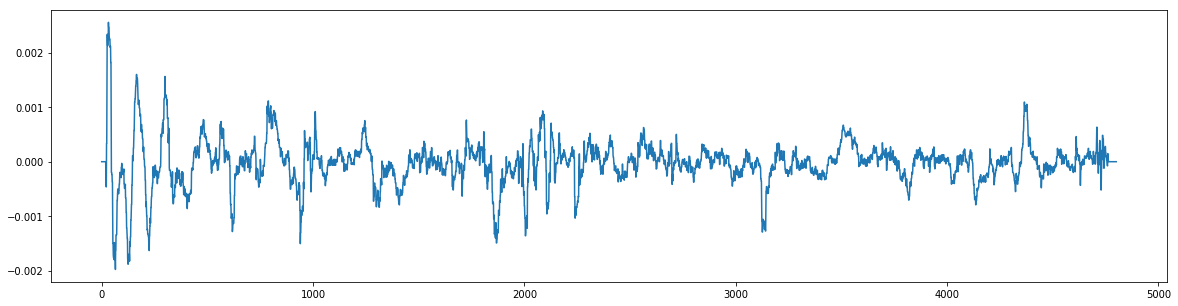

In [10]:
def calc_factor(df):
    index_pmr_period = np.log(df["mp"]/df["mp"].shift(20))
    index_pmr_period = index_pmr_period.fillna(0)
    index_pmr_period = index_pmr_period

    return index_pmr_period   

sample_df = pd.read_csv("sample_data.csv", index_col=0)
f, ax = plt.subplots(figsize=(20, 5))
plt.plot(calc_factor(sample_df))
plt.show()

+----------+----------+---------------+---------------+---------------+---------------+---------------+---------------+
|   mean   |   std    | y_mid_10_corr | y_mid_10_mean | y_mid_30_corr | y_mid_30_mean | y_mid_60_corr | y_mid_60_mean |
+----------+----------+---------------+---------------+---------------+---------------+---------------+---------------+
| 0.001891 | 1.972578 |    0.859295   |    0.000979   |    0.844587   |    0.00223    |    0.59195    |    0.002397   |
+----------+----------+---------------+---------------+---------------+---------------+---------------+---------------+


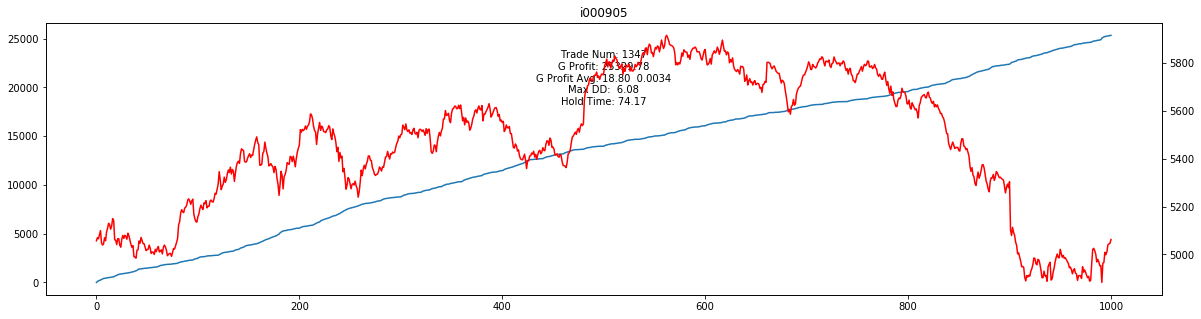

+-----------+--------+----------+--------------+----------+
| hold_time |  num   |  profit  | profit_total | win_rate |
+-----------+--------+----------+--------------+----------+
| 74.173719 | 1347.0 | 0.003475 |   4.681355   | 0.999258 |
+-----------+--------+----------+--------------+----------+


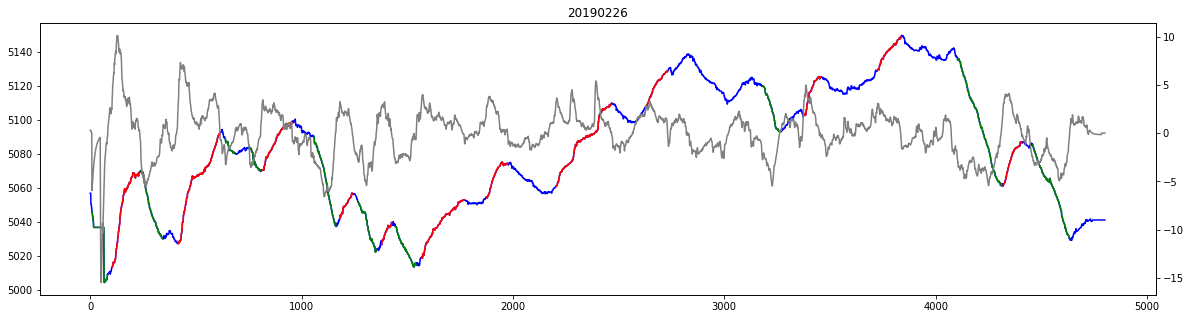

In [11]:
code_str = """
import talib
from scipy.optimize import leastsq
def calc_factor(df):
    macd, macdsignal, macdhist = talib.MACD(df['mp'], fastperiod=12, slowperiod=26, signalperiod=9)
    macd = macd.fillna(0)
    macdsignal = macdsignal.fillna(0)
    index_macd = macd-macdsignal
    index_macd = (index_macd-np.mean(index_macd))/np.std(index_macd)
    # 价格距离
    d = 50
    HP = []
    for i in range(d):
        HP.append(1)
    for i in range(d,len(df)):
        ind_max = np.max(df['mp'].iloc[i-d:i])
        ind_HP = df['mp'].iloc[i]/ind_max
        HP.append(ind_HP)
    index_HP = pd.Series(np.log(HP))
    # 指数评价
    EMA_l = talib.MA(df['mp'],26,matype=1)
    EMA_s = talib.MA(df['mp'],4,matype=1)
    index = EMA_s - EMA_l
    index = index.fillna(0)
    # 价量关系
    V = df['val']/df['mp']
    def get_V(V,n=10):    # 可以考虑加权平均，把更多的注意放到最近的日期
        temp = []
        for i in range(1,n+1):
            temp.append(np.sum(V[:i])/n)
        for i in range(n,len(V)):
            V_n = np.sum(V[i-n:i+1])/n
            temp.append(V_n)
        return temp
    #a=get_V(V)
    b=EMA_l/talib.MA(V,30,matype=1)
    b[np.isinf(b)]=0
    b=(b-np.mean(b))/np.std(b)
    index = 0.9*index+10.5*index_HP+0.1*b+0.01*index_macd
     # 中性化
    max_range = index.quantile(0.9)
    min_range = index.quantile(0.1)
    for i in range(len(index)):
        if index[i]>max_range:
            index[i]=max_range
        elif index[i]<min_range:
            index[i]=min_range

    return index
    
"""
para["factor"] = code_str
result_core = factor_post(client_id, para)

In [ ]:
# 为了减少带宽传输，所以进出场图只可以查看回测的前3天
#"20190201","20190211", "20190212"
plt_oneday("20190211", result_core)

In [ ]:
# 这个函数是获取最新排名信息，只记录每个人最好的因子
# 排序的依据是交易次数大于100的因子 按单笔盈利排序
factor_rank(client_id)